In [7]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

100%|██████████| 2.29G/2.29G [00:17<00:00, 144MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2


In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50V2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Conv2D, MaxPooling2D, Activation, Flatten
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import pandas as pd
from PIL import Image
import random




In [8]:
# Paths to datasets (Assume organized as train, validation, test directories)
base_dir = '/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

Performing EDA on Training Data...


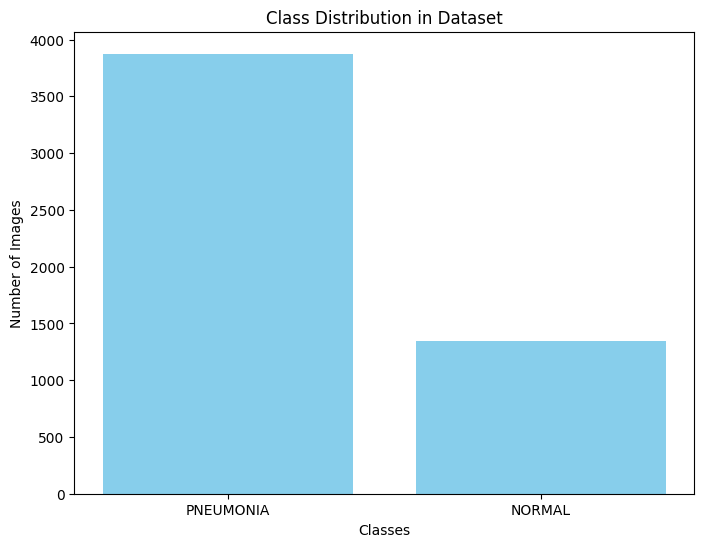

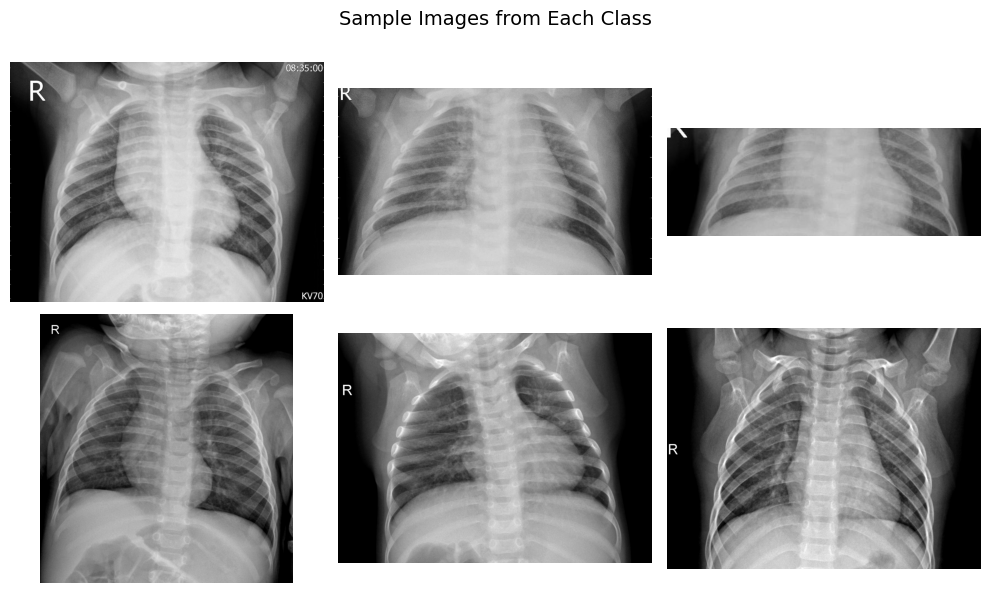

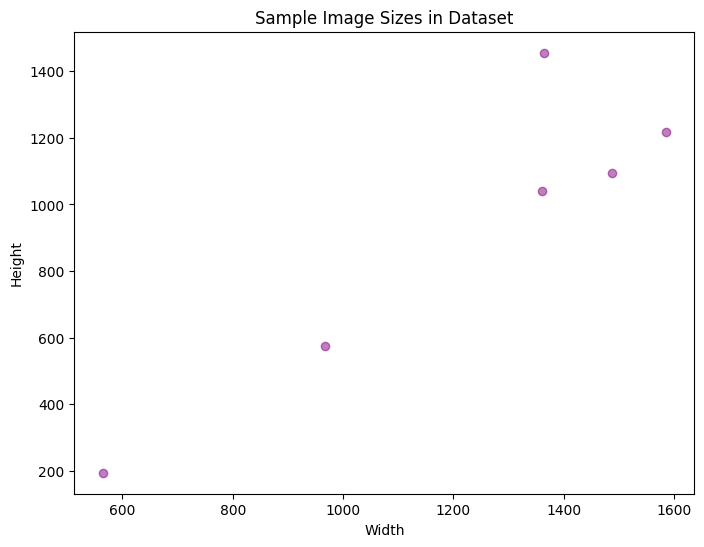

Mean Image Width: 1221.67, Mean Image Height: 929.50
Total Classes: 2, Total Images: 5216


In [11]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

def perform_eda(directory):
    """
    Perform exploratory data analysis (EDA) on a given dataset directory.
    Includes class distribution, sample visualization, and basic image statistics.
    """
    class_counts = {}
    image_sizes = []
    sample_images = {}

    # Collect class counts and image statistics
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            num_images = len(os.listdir(class_path))
            class_counts[class_name] = num_images

            # Collect sample images for visualization
            image_files = os.listdir(class_path)[:3]  # Limit to 3 samples per class
            sample_images[class_name] = [
                os.path.join(class_path, img) for img in image_files
            ]

            # Record image sizes
            for image_name in image_files:
                image_path = os.path.join(class_path, image_name)
                with Image.open(image_path) as img:
                    image_sizes.append(img.size)

    # Plot Class Distribution
    plt.figure(figsize=(8, 6))
    plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.title('Class Distribution in Dataset')
    plt.show()

    # Plot Sample Images
    plt.figure(figsize=(10, 6))
    for idx, (class_name, image_paths) in enumerate(sample_images.items()):
        for i, img_path in enumerate(image_paths):
            with Image.open(img_path) as img:
                plt.subplot(len(sample_images), len(image_paths), idx * len(image_paths) + i + 1)
                plt.imshow(img, cmap='gray')
                plt.axis('off')
                if i == 0:
                    plt.ylabel(class_name, fontsize=12, labelpad=10)
    plt.suptitle('Sample Images from Each Class', fontsize=14)
    plt.tight_layout()
    plt.show()

    # Plot Image Size Distribution
    widths, heights = zip(*image_sizes)
    plt.figure(figsize=(8, 6))
    plt.scatter(widths, heights, alpha=0.5, color='purple')
    plt.xlabel('Width')
    plt.ylabel('Height')
    plt.title('Sample Image Sizes in Dataset')
    plt.show()

    # Print image statistics
    mean_width = np.mean(widths)
    mean_height = np.mean(heights)
    print(f"Mean Image Width: {mean_width:.2f}, Mean Image Height: {mean_height:.2f}")
    print(f"Total Classes: {len(class_counts)}, Total Images: {sum(class_counts.values())}")

# Perform EDA on Training Dataset
print("Performing EDA on Training Data...")
perform_eda(train_dir)


In [13]:
# Data Augmentation and Preprocessing
data_gen = ImageDataGenerator(rescale=1.0/255,
                              rotation_range=30,
                              width_shift_range=0.2,
                              height_shift_range=0.2,
                              shear_range=0.2,
                              zoom_range=0.2,
                              horizontal_flip=True)

In [14]:
def create_generators(train_dir, val_dir, test_dir, target_size=(224, 224), batch_size=32):
    train_gen = data_gen.flow_from_directory(
        train_dir, target_size=target_size, batch_size=batch_size, class_mode='binary'
    )

    val_gen = ImageDataGenerator(rescale=1.0/255).flow_from_directory(
        val_dir, target_size=target_size, batch_size=batch_size, class_mode='binary'
    )

    test_gen = ImageDataGenerator(rescale=1.0/255).flow_from_directory(
        test_dir, target_size=target_size, batch_size=batch_size, class_mode='binary', shuffle=False
    )

    return train_gen, val_gen, test_gen

train_gen, val_gen, test_gen = create_generators(train_dir, val_dir, test_dir)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [15]:
# Build Transfer Learning Models
def build_model(base_model):
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    return model


In [16]:
# Load Pretrained Models
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
resnet_base = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

vgg_base.trainable = False  # Freeze VGG16 layers
resnet_base.trainable = False  # Freeze ResNet50V2 layers

vgg_model = build_model(vgg_base)
resnet_model = build_model(resnet_base)


In [24]:

# CNN Model from Scratch
def build_cnn_model(input_shape, num_classes):
    model = Sequential()

    model.add(Conv2D(32, (3, 3), input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(128, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(64))
    model.add(Activation('relu'))

    model.add(Dense(num_classes))
    model.add(Activation('sigmoid'))

    return model

cnn_model = build_cnn_model(input_shape=(224, 224, 3), num_classes=1)



In [25]:

# Compile Models with Separate Optimizers
vgg_optimizer = Adam(learning_rate=0.0001)
resnet_optimizer = Adam(learning_rate=0.0001)
cnn_optimizer = RMSprop(learning_rate=0.0001)

vgg_model.compile(optimizer=vgg_optimizer, loss='binary_crossentropy', metrics=['accuracy'])
resnet_model.compile(optimizer=resnet_optimizer, loss='binary_crossentropy', metrics=['accuracy'])
cnn_model.compile(optimizer=cnn_optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [26]:
# Train Models
def train_model(model, train_gen, val_gen, epochs=10):
    history = model.fit(train_gen, validation_data=val_gen, epochs=epochs)
    return history

print("Training VGG16 Model...")
vgg_history = train_model(vgg_model, train_gen, val_gen)

print("Training ResNet50V2 Model...")
resnet_history = train_model(resnet_model, train_gen, val_gen)

print("Training CNN Model from Scratch...")
cnn_history = train_model(cnn_model, train_gen, val_gen)


Training VGG16 Model...
Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 107s 609ms/step - accuracy: 0.8814 - loss: 0.2778 - val_accuracy: 0.7500 - val_loss: 0.5170
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 140s 608ms/step - accuracy: 0.8878 - loss: 0.2749 - val_accuracy: 0.7500 - val_loss: 0.4945
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 139s 599ms/step - accuracy: 0.8716 - loss: 0.2779 - val_accuracy: 0.7500 - val_loss: 0.4618
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 104s 606ms/step - accuracy: 0.9041 - loss: 0.2513 - val_accuracy: 0.7500 - val_loss: 0.4701
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 103s 602ms/step - accuracy: 0.9052 - loss: 0.2392 - val_accuracy: 0.7500 - val_loss: 0.4630
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 104s 617ms/step - accuracy: 0.8965 - loss: 0.2581 - val_accuracy: 0.7500 - val_loss: 0.4724
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 143s 620ms/step - accuracy: 0.8987 - loss: 0.2479 - val_accuracy: 0.7500 - val_loss: 0.4990
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 140s 607ms/s

Evaluating VGG16 Model...
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 264ms/step
              precision    recall  f1-score   support

           0       0.82      0.83      0.83       234
           1       0.90      0.89      0.89       390

    accuracy                           0.87       624
   macro avg       0.86      0.86      0.86       624
weighted avg       0.87      0.87      0.87       624



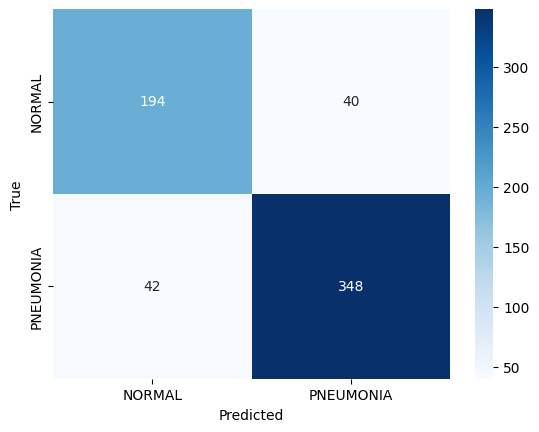

Evaluating ResNet50V2 Model...
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 372ms/step
              precision    recall  f1-score   support

           0       0.92      0.84      0.88       234
           1       0.91      0.96      0.93       390

    accuracy                           0.91       624
   macro avg       0.92      0.90      0.91       624
weighted avg       0.91      0.91      0.91       624



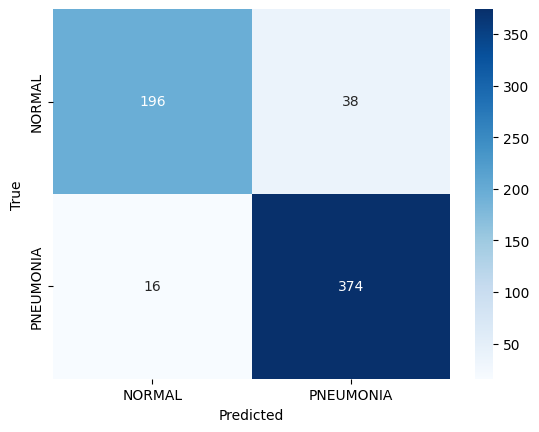

Evaluating CNN Model
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 248ms/step
              precision    recall  f1-score   support

           0       0.73      0.93      0.82       234
           1       0.95      0.79      0.86       390

    accuracy                           0.84       624
   macro avg       0.84      0.86      0.84       624
weighted avg       0.87      0.84      0.85       624



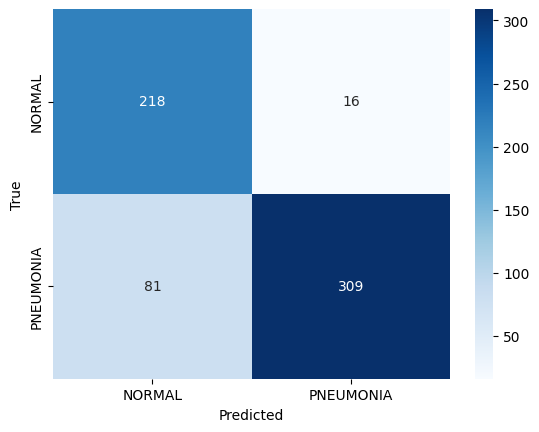

In [36]:
# Evaluate Model
def evaluate_model(model, test_gen):
    y_pred = (model.predict(test_gen) > 0.5).astype(int)
    y_true = test_gen.classes
    print(classification_report(y_true, y_pred))

    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_gen.class_indices.keys(), yticklabels=test_gen.class_indices.keys())
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

print("Evaluating VGG16 Model...")
vgg_pred = evaluate_model(vgg_model, test_gen)

print("Evaluating ResNet50V2 Model...")
resnet_pred = evaluate_model(resnet_model, test_gen)

print("Evaluating CNN Model")
cnn_pred = evaluate_model(cnn_model, test_gen)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


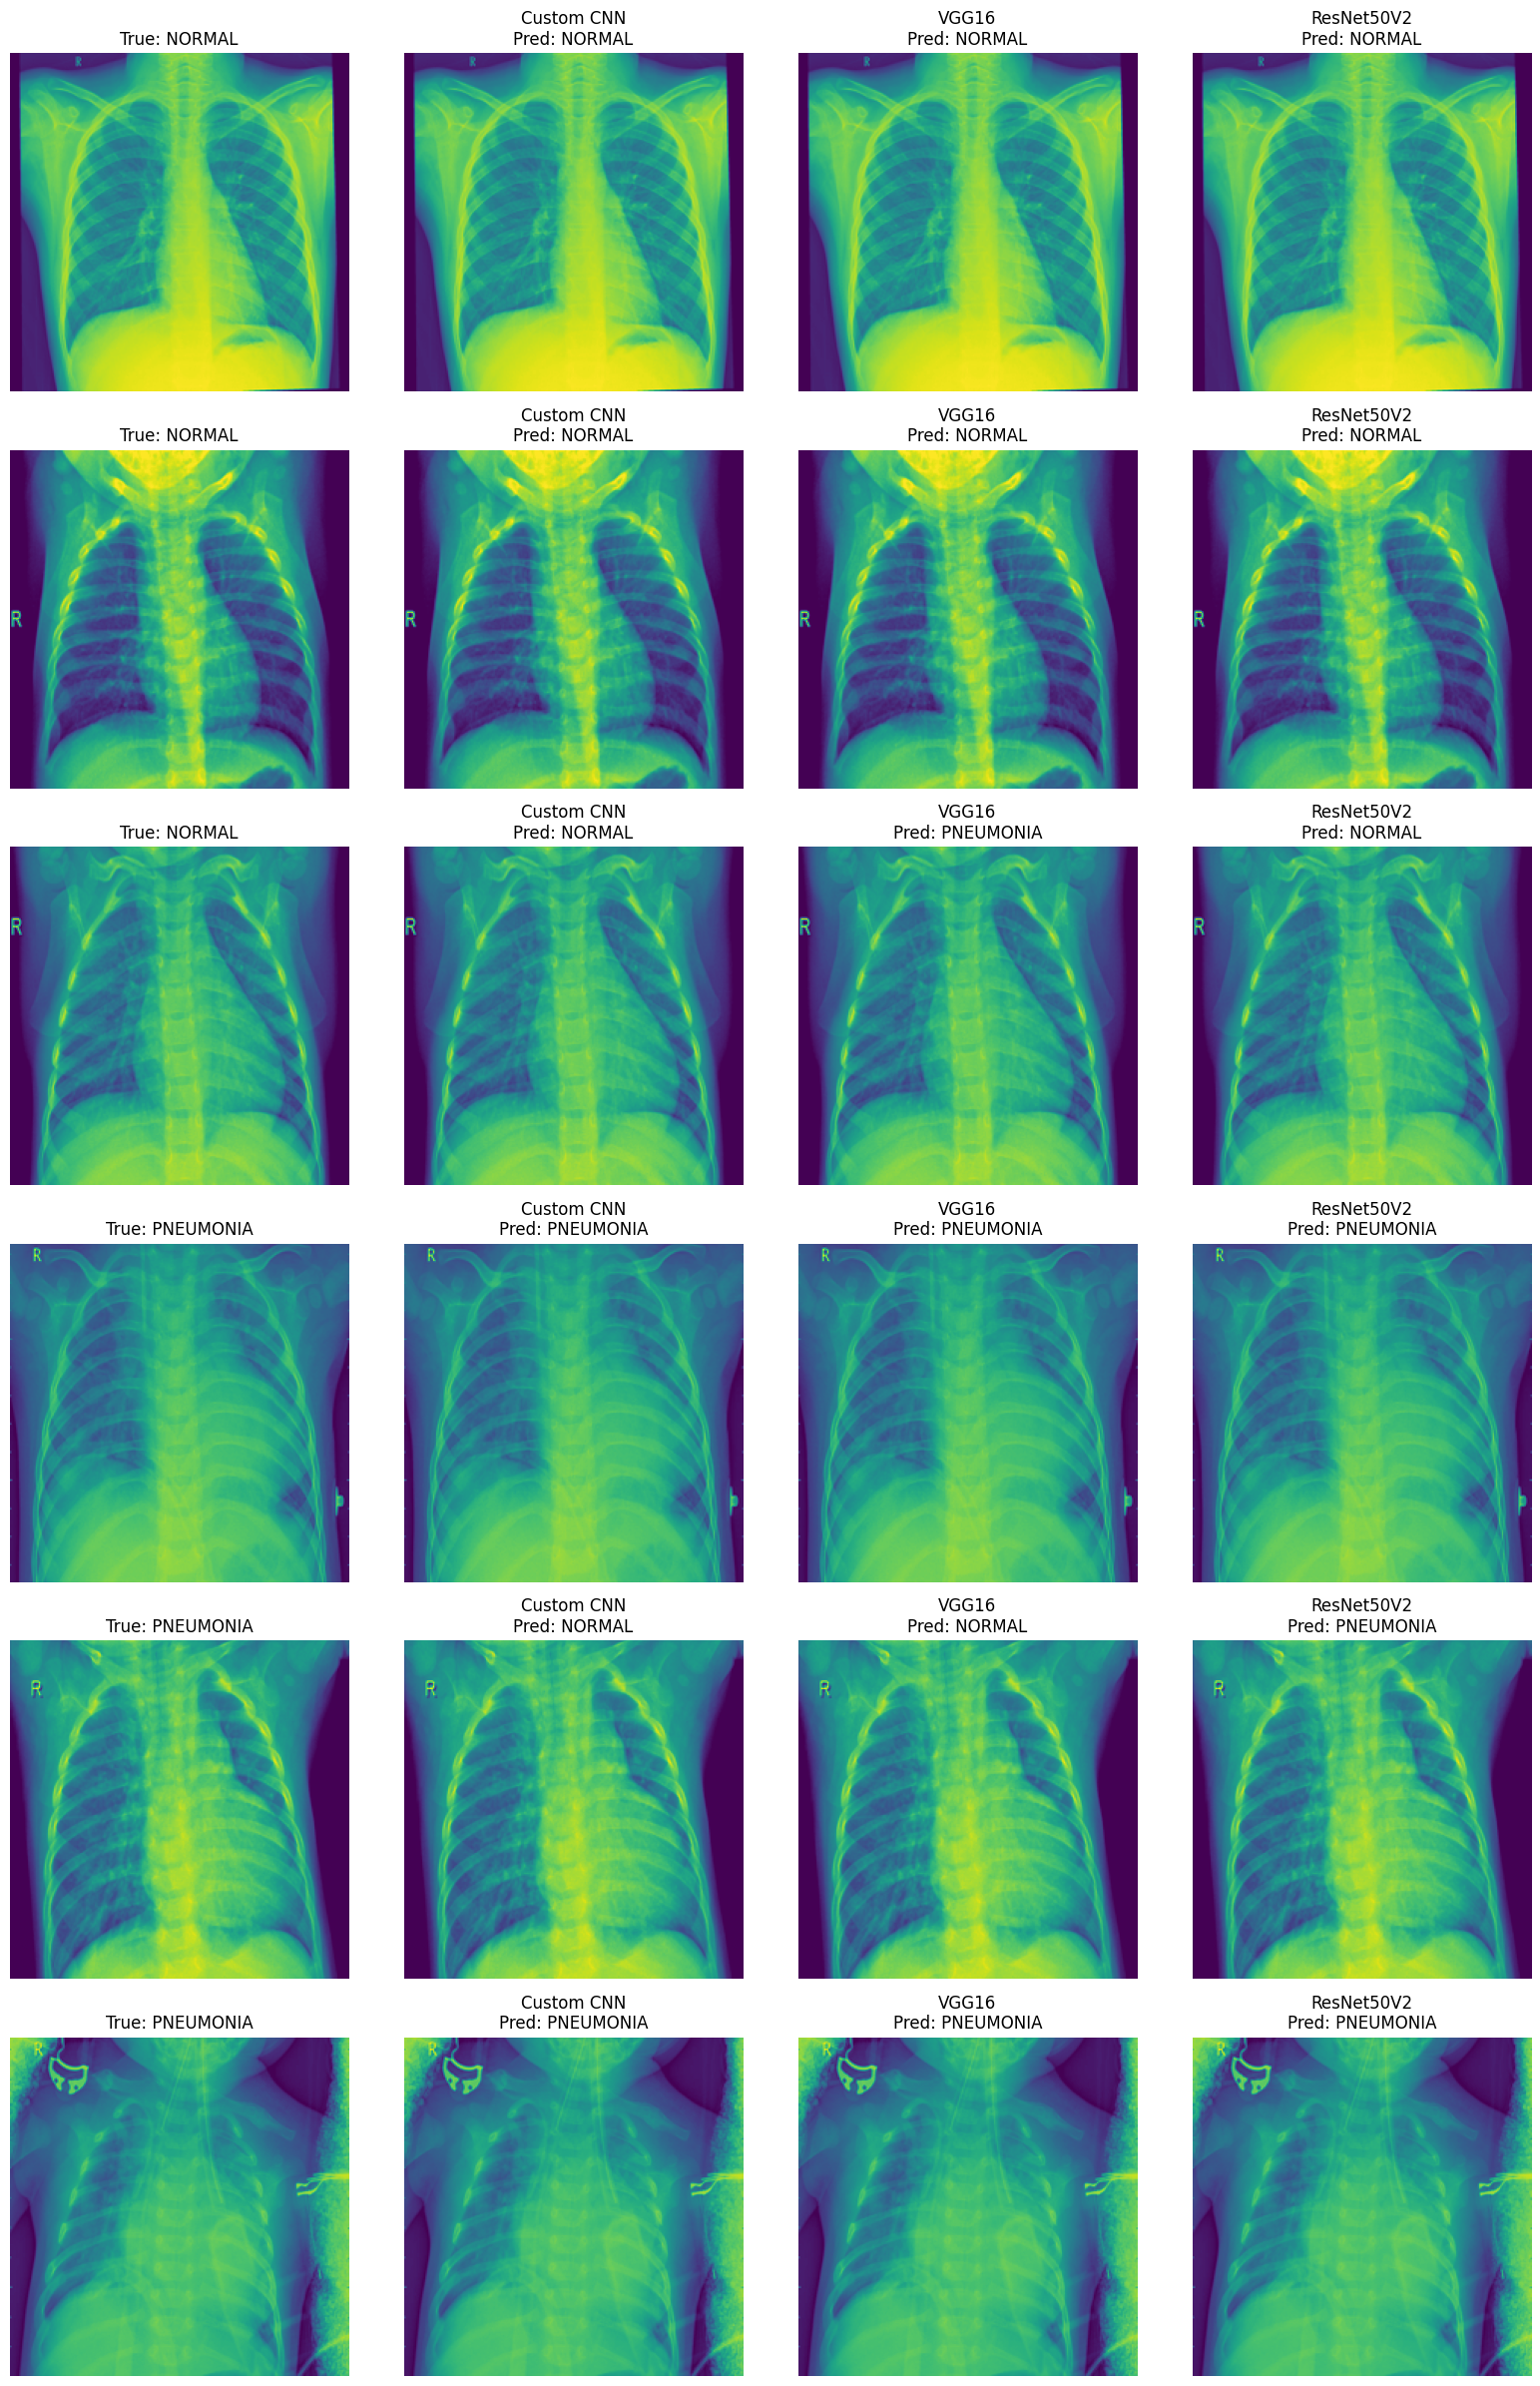

In [47]:
def display_examples_with_predictions(models, model_names, test_gen, num_samples_per_class=3):

    class_labels = list(test_gen.class_indices.keys())
    filepaths = test_gen.filepaths
    labels = test_gen.classes

    data = pd.DataFrame({'filepath': filepaths, 'label': labels})
    samples = []

    # Sample a few images from each class
    for label in np.unique(labels):
        class_samples = data[data['label'] == label].sample(n=num_samples_per_class, random_state=42)
        samples.append(class_samples)

    samples = pd.concat(samples).reset_index(drop=True)

    # Calculate grid dimensions
    total_images = len(samples)
    num_models = len(models)
    total_columns = num_models + 1
    total_rows = total_images
    plt.figure(figsize=(total_columns * 4, total_rows * 4))

    for i, row in samples.iterrows():
        filepath, true_label = row['filepath'], row['label']
        img = Image.open(filepath).resize((224, 224))
        img_array = np.array(img) / 255.0
        if img_array.ndim == 2:
            img_array = np.stack((img_array,) * 3, axis=-1)

        # Plot true label
        plt.subplot(total_rows, total_columns, i * total_columns + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"True: {class_labels[true_label]}")

        # Plot predictions for each model
        for j, (model, model_name) in enumerate(zip(models, model_names)):
            pred_label = (model.predict(np.expand_dims(img_array, axis=0)) > 0.5).astype(int)[0][0]
            plt.subplot(total_rows, total_columns, i * total_columns + j + 2)
            plt.imshow(img)
            plt.axis('off')
            plt.title(f"{model_name}\nPred: {class_labels[pred_label]}")

    plt.tight_layout()
    plt.show()

# List of trained models and their names
models = [cnn_model, vgg_model, resnet_model]
model_names = ["Custom CNN", "VGG16", "ResNet50V2"]

# Display predictions for all models
display_examples_with_predictions(models, model_names, test_gen, num_samples_per_class=3)


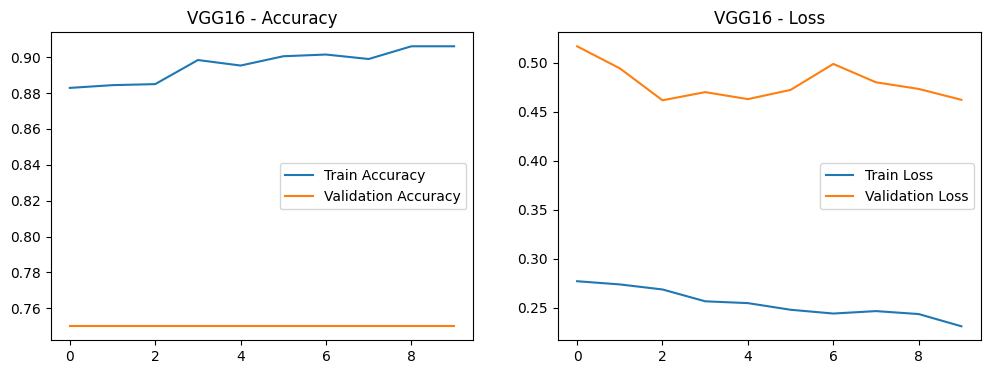

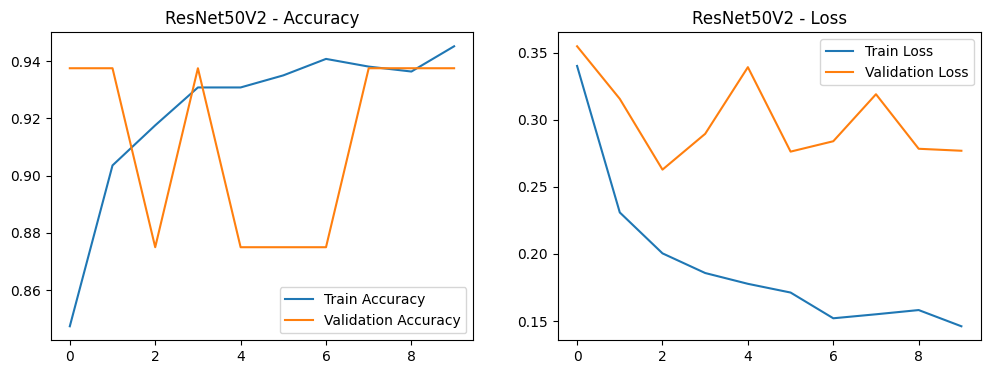

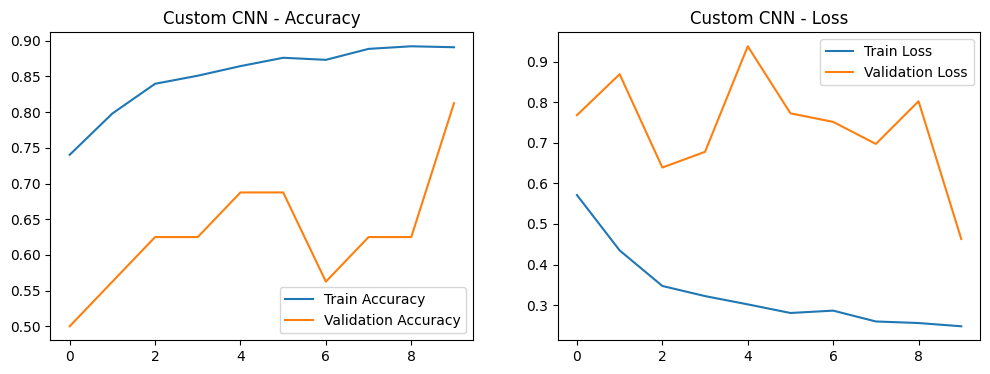

In [31]:
# Visualize Training History
def plot_training_history(history, title):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title(f'{title} - Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title(f'{title} - Loss')
    plt.show()

plot_training_history(vgg_history, "VGG16")
plot_training_history(resnet_history, "ResNet50V2")
plot_training_history(cnn_history, "Custom CNN")